# Exploratory analyses

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import seaborn as sns
import psycopg2 as pg
import sql_utils
import os
import sys
import io
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# plotting style
sns.set(font_scale=1.35, style="whitegrid")

## Pull data from postgreSQL db

In [3]:
# select and join the BART and weather data from postgres
bart_stn_df = sql_utils.pg2pd_join(table1='bart_entry_exit', table2='bart_station_info',
                           on1='bart_entry_exit.station', on2='bart_station_info.abbr')

In [4]:
# drop redundant columns
bart_stn_df.drop(['exits', 'abbr', 'address', 'city', 'county', 'gtfs_latitude', 
                  'gtfs_longitude', 'name', 'state', 'zipcode'], axis=1, inplace=True)

In [5]:
# now get weather data from db. we will join in pandas
sql_query = '''
    SELECT datestamp, wu_loc_abbr, max_temperature, precipitation, rain FROM weather;
    '''
dbname = 'bart_db'
username = 'bkhurley'
con = None
con = pg.connect(database=dbname, user=username)
# query db and return in a df
weather_df = pd.read_sql_query(sql_query,con)

In [6]:
# merge weather data with BART data
bart_weather_df = pd.merge(left=bart_stn_df, right=weather_df, 
                           left_on=['date', 'wu_loc_abbr'],
                           right_on=['datestamp', 'wu_loc_abbr'])
# remove redundant datestamp col
bart_weather_df.drop(['datestamp'], axis=1, inplace=True)

In [7]:
bart_weather_df.head()

,id,date,hour,direction,station,entries,day,month,index,wu_loc_abbr,max_temperature,precipitation,rain
0,0,2011-01-01,0,northbound,12TH,16,Saturday,1,0,KOAK,53.0,0.08,1
1,2,2011-01-01,0,northbound,19TH,19,Saturday,1,2,KOAK,53.0,0.08,1
2,12,2011-01-01,0,northbound,MCAR,7,Saturday,1,24,KOAK,53.0,0.08,1
3,16,2011-01-01,0,northbound,ROCK,2,Saturday,1,35,KOAK,53.0,0.08,1
4,20,2011-01-01,0,northbound,WOAK,10,Saturday,1,45,KOAK,53.0,0.08,1


In [8]:
bart_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126069 entries, 0 to 2126068
Data columns (total 13 columns):
id                 int64
date               object
hour               object
direction          object
station            object
entries            int64
day                object
month              object
index              int64
wu_loc_abbr        object
max_temperature    float64
precipitation      float64
rain               int64
dtypes: float64(2), int64(4), object(7)
memory usage: 227.1+ MB


In [9]:
bart_weather_df['entries'].describe()

count    2.126069e+06
mean     1.710445e+02
std      3.090924e+02
min      1.000000e+00
25%      1.600000e+01
50%      6.100000e+01
75%      1.940000e+02
max      4.412000e+03
Name: entries, dtype: float64

## Check out the distribution

In [10]:
figpath = '/Users/bkhurley/git/insight/project/beat_the_crowd/figures/'

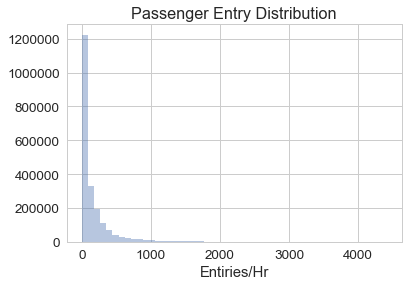

In [12]:
hist = sns.distplot(bart_weather_df['entries'], kde=False)
plt.title('Passenger Entry Distribution')
plt.xlabel('Entiries/Hr')
plt.savefig(figpath + 'entries_dist_all.png', 
    dpi=300)

1261440

### Identify outliers

In [13]:
# function for identifying outliers using the Z-score method
def outliers_z_score(ys):
    threshold = 3 #setting the outlier criterion as 3 SDs

    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)

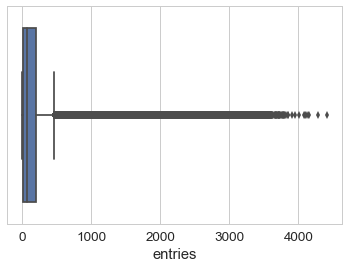

In [14]:
sns.boxplot(bart_weather_df['entries'])

The above plot looks like we have a ton of outliers. However, this likely reflects the sknewedness of entry data. Look below and we see that the very large (i.e. > 3 SDs) entry values correspond to what one might expect to be busy times/stations.

In [15]:
outlier_idx = outliers_z_score(bart_weather_df['entries'])
outlier_data = bart_weather_df.iloc[outlier_idx]

In [18]:
outlier_data

,id,date,hour,direction,station,entries,day,month,index,wu_loc_abbr,max_temperature,precipitation,rain
46,1351035,2015-01-12,7,southbound,PHIL,1339,Monday,1,32,KCCR,66.0,0.0,0
47,1351041,2015-01-12,7,southbound,WCRK,1113,Monday,1,42,KCCR,66.0,0.0,0
53,1351073,2015-01-12,8,southbound,CONC,1229,Monday,1,11,KCCR,66.0,0.0,0
57,1351082,2015-01-12,8,southbound,PHIL,1929,Monday,1,32,KCCR,66.0,0.0,0
69,1351130,2015-01-12,9,southbound,PHIL,1240,Monday,1,32,KCCR,66.0,0.0,0
325,1350999,2015-01-12,7,northbound,BALB,1552,Monday,1,5,KSFO,62.0,0.0,0
328,1351003,2015-01-12,7,northbound,DALY,1140,Monday,1,12,KSFO,62.0,0.0,0
350,1351046,2015-01-12,8,northbound,24TH,1945,Monday,1,3,KSFO,62.0,0.0,0
351,1351047,2015-01-12,8,northbound,BALB,2056,Monday,1,5,KSFO,62.0,0.0,0
353,1351049,2015-01-12,8,northbound,COLM,1111,Monday,1,10,KSFO,62.0,0.0,0


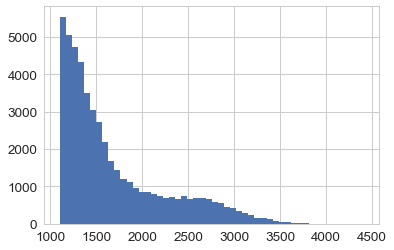

In [24]:
# what kind of entry values are in the outliers?
outlier_data['entries'].hist(bins=50)

### Get normalized crowd levels for each station

Let's get a sense of what constitutes low crowd level, medium crowd level, high crowd level for each station 

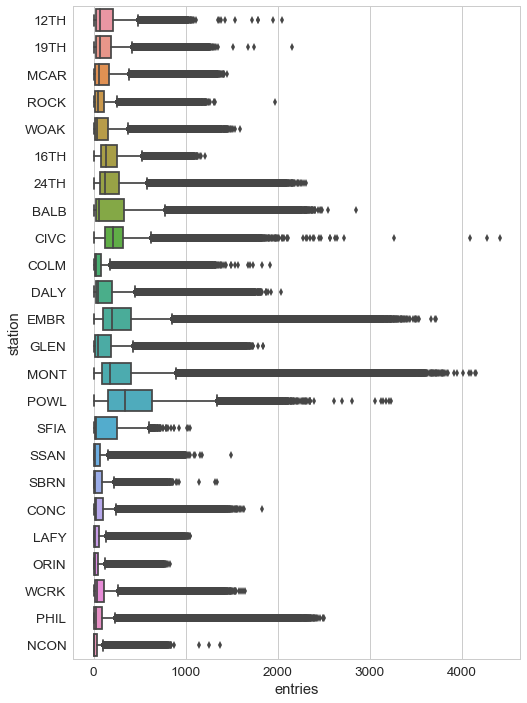

In [25]:
f, ax = plt.subplots(figsize=(8, 12))
sns.boxplot(x=bart_weather_df['entries'], y=bart_weather_df['station'])

Look at an example Z distribution for a lower volume station (N Concord)

In [26]:
ncon_df = bart_weather_df.loc[bart_weather_df['station']=='NCON', :]
powl_df = bart_weather_df.loc[bart_weather_df['station']=='POWL', :]

Text(0.5,1,'Z distribution - NCON station')

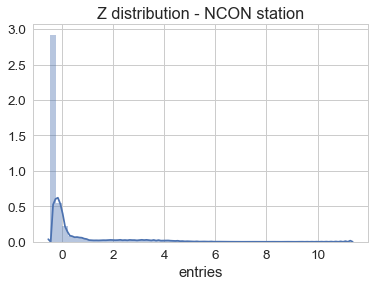

In [27]:
ncon_z = (ncon_df['entries'] - ncon_df['entries'].mean())/np.std(ncon_df['entries'])
sns.distplot(ncon_z)
plt.title('Z distribution - NCON station')

In [28]:
len(ncon_z[ncon_z>3])

2693

Text(0.5,1,'Z distribution - POWL station')

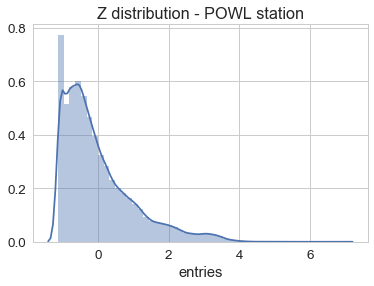

In [29]:
powl_z = (powl_df['entries'] - powl_df['entries'].mean())/np.std(powl_df['entries'])
sns.distplot(powl_z)
plt.title('Z distribution - POWL station')

Get mean and standard deviations of the stations and output to a csv. I will use this for calculating z-scores for normalized crowd levels in the app.

In [30]:
station_mean_df = bart_weather_df[['station', 'entries']].groupby('station').mean()
station_std_df = bart_weather_df[['station', 'entries']].groupby('station').std()

In [31]:
# change column names to mean and std
station_mean_df.rename(columns={"entries": "mean"}, inplace=True)
station_std_df.rename(columns={"entries": "std"}, inplace=True)
# reset index so station is a column
station_mean_df.reset_index(inplace=True)
station_std_df.reset_index(inplace=True)

In [32]:
stn_mean_std_df = pd.merge(left=station_mean_df, right=station_std_df, on='station')
stn_mean_std_df.head()

,station,mean,std
0,12TH,150.079919,182.205143
1,16TH,188.709591,169.584815
2,19TH,145.415197,188.248723
3,24TH,219.182143,287.108951
4,BALB,223.590238,355.556628


In [33]:
# write the above data to file so we can use it to calculate z-scores in the flask app
stn_mean_std_df.to_csv('/Users/bkhurley/git/insight/project/beat_the_crowd/data/stn_mean_std.csv', index=False, header=True)

### Generate some plots

In [56]:
# restrict plotting to the following sample of stations
stations_to_plt = ['PHIL', 'MONT']
plot_df = bart_weather_df.loc[bart_weather_df['station'].isin(stations_to_plt), :]
plot_df['hour'] = pd.to_numeric(plot_df['hour'])
# separate s-bound & n-bound directions
plot_nb_df = plot_df.loc[plot_df['direction']=='northbound']
plot_nb_df.drop(labels=['id'], axis=1, inplace=True)
plot_sb_df = plot_df.loc[plot_df['direction']=='southbound']
plot_sb_df.drop(labels=['id'], axis=1, inplace=True)

Look at temporal trends

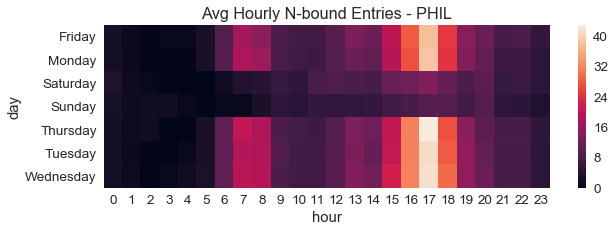

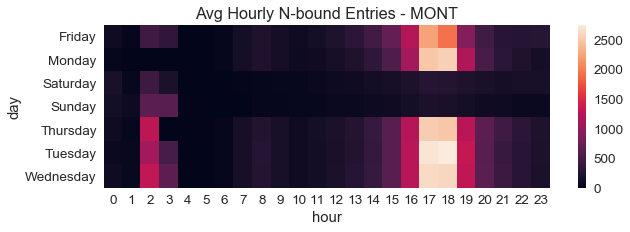

In [57]:
for stn in stations_to_plt:
    # filter for the Mcarthur station
    stn_df = plot_nb_df.loc[plot_nb_df['station']==stn, :]

    # avg by station by hour, day, month
    #mean_df = stn_df.groupby(by=['station', 'day', 'hour']).mean()['entries']
    #mean_df.fillna(value=0, inplace=True)
    
    day_hour_avg = stn_df.groupby(by=['day', 'hour']).mean()['entries'].unstack()
    day_hour_avg.fillna(value=0, inplace=True)
    
    # plot heat map of the days and hours with most rides
    plt.subplots(figsize=(10, 3))
    sns.heatmap(day_hour_avg)
    plt.title('Avg Hourly N-bound Entries - ' + stn)
    plt.savefig(figpath + 'station_heatmap_' + stn + '_nbound.png', bbox_inches='tight')

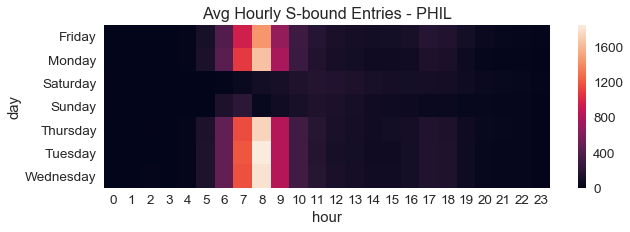

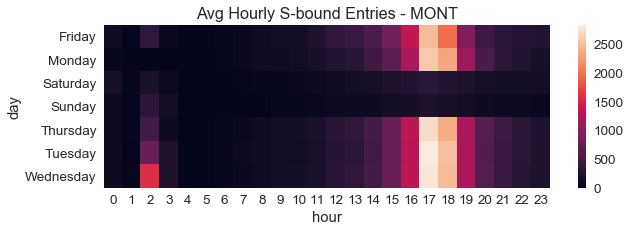

In [58]:
for stn in stations_to_plt:
    # filter for the Mcarthur station
    stn_df = plot_sb_df.loc[plot_sb_df['station']==stn, :]

    # avg by station by hour, day, month
    #mean_df = stn_df.groupby(by=['station', 'day', 'hour']).mean()['entries']
    #mean_df.fillna(value=0, inplace=True)
    
    day_hour_avg = stn_df.groupby(by=['day', 'hour']).mean()['entries'].unstack()
    day_hour_avg.fillna(value=0, inplace=True)
    
    # plot heat map of the days and hours with most rides
    plt.subplots(figsize=(10, 3))
    sns.heatmap(day_hour_avg)
    plt.title('Avg Hourly S-bound Entries - ' + stn)
    plt.savefig(figpath + 'station_heatmap_' + stn + '_sbound.png', bbox_inches='tight')

#### Avg hourly trips M-F

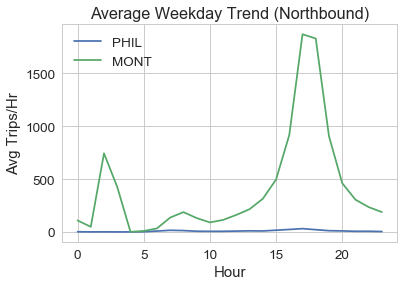

In [153]:
plt.subplots()
for stn in stations_to_plt:
    # filter for the Mcarthur station
    stn_df = plot_nb_df.loc[plot_nb_df['station']==stn, :]
    # look at weekdays only
    # create a weekday dummy variable
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    weekday_df = stn_df.loc[stn_df['day'].isin(weekdays), :]
    # avg by station by hour
    mean_df = stn_df[['entries', 'hour']].groupby(by='hour').mean()
    
    # make hour numeric
    mean_df.reset_index(inplace=True)
    mean_df['hour'] = pd.to_numeric(mean_df['hour'])
    mean_df.sort_values(by='hour', inplace=True)
    mean_df.reset_index(inplace=True)
    
    plt.plot(mean_df['hour'], mean_df['entries'])

plt.legend([stations_to_plt[0], stations_to_plt[1]])
plt.title('Average Weekday Trend (Northbound)')
plt.ylabel('Avg Trips/Hr')
plt.xlabel('Hour')
plt.savefig(figpath + 'hourly_nbound.png', bbox_inches='tight')

Where's that 2AM spike coming from?

In [61]:
plot_nb_df.loc[(plot_nb_df['station'] == 'MONT') &
               (plot_nb_df['hour'] > 0) &
               (plot_nb_df['hour'] < 4) &
               (plot_nb_df['entries'] > 200), :]

,date,hour,direction,station,entries,day,month,index,wu_loc_abbr,max_temperature,precipitation,rain
229,2011-01-01,1,northbound,MONT,1805,Saturday,1,26,KSFO,52.0,0.09,1
249,2011-01-01,2,northbound,MONT,817,Saturday,1,26,KSFO,52.0,0.09,1
270,2011-01-01,3,northbound,MONT,390,Saturday,1,26,KSFO,52.0,0.09,1
333762,2012-01-01,1,northbound,MONT,2325,Sunday,1,26,KSFO,58.0,0.00,0
333786,2012-01-01,2,northbound,MONT,1214,Sunday,1,26,KSFO,58.0,0.00,0
333804,2012-01-01,3,northbound,MONT,644,Sunday,1,26,KSFO,58.0,0.00,0
671460,2013-01-01,1,northbound,MONT,2297,Tuesday,1,26,KSFO,53.0,0.00,0
671481,2013-01-01,2,northbound,MONT,1116,Tuesday,1,26,KSFO,53.0,0.00,0
671499,2013-01-01,3,northbound,MONT,510,Tuesday,1,26,KSFO,53.0,0.00,0
1001954,2014-01-01,1,northbound,MONT,1869,Wednesday,1,26,KSFO,56.0,0.00,0


Looks like the 2AM jump in passenger volume is from New Year's Eve partiers.

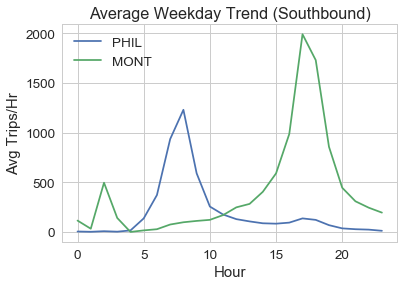

In [154]:
fig, x = plt.subplots()
for stn in stations_to_plt:
    # filter for the Mcarthur station
    stn_df = plot_sb_df.loc[plot_sb_df['station']==stn, :]
    # look at weekdays only
    # create a weekday dummy variable
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    weekday_df = stn_df.loc[stn_df['day'].isin(weekdays), :]
    # avg by station by hour
    mean_df = stn_df[['entries', 'hour']].groupby(by='hour').mean()
    
    # make hour numeric
    mean_df.reset_index(inplace=True)
    mean_df['hour'] = pd.to_numeric(mean_df['hour'])
    mean_df.sort_values(by='hour', inplace=True)
    mean_df.reset_index(inplace=True)
    
    plt.plot(mean_df['hour'], mean_df['entries'])

plt.legend([stations_to_plt[0], stations_to_plt[1]])
plt.title('Average Weekday Trend (Southbound)')
plt.ylabel('Avg Trips/Hr')
plt.xlabel('Hour')
plt.savefig(figpath + 'hourly_sbound.png', bbox_inches='tight')

#### Are there any monthly trends?

Text(0.5,0,'Month')

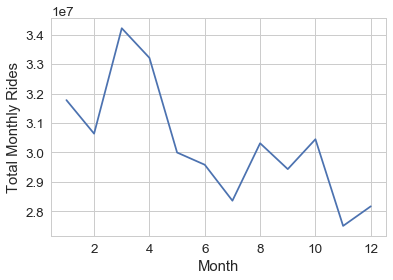

In [106]:
fig, x = plt.subplots()
# across all stations, look at total # rides per month
month_sum_df = bart_weather_df[['entries', 'month']].groupby(by='month').sum()
month_sum_df.reset_index(inplace=True)
month_sum_df['month'] = pd.to_numeric(month_sum_df['month'])
month_sum_df.sort_values(by='month', inplace=True)
# month_avg_df.reset_index(inplace=True)

plt.plot(month_sum_df['month'], month_sum_df['entries'])
plt.ylabel('Total Monthly Rides')
plt.xlabel('Month')

In [112]:
month_temp_df = bart_weather_df[['max_temperature', 'month']].groupby(by='month').mean()
month_temp_df.reset_index(inplace=True)
month_temp_df['month'] = pd.to_numeric(month_sum_df['month'])
month_temp_df.sort_values(by='month', inplace=True)

In [113]:
month_temp_df

,month,max_temperature
0,1,58.736968
4,2,61.912928
5,3,64.793433
6,4,67.892052
7,5,70.089969
8,6,74.104461
9,7,75.305415
10,8,75.353619
11,9,76.522113
1,10,73.758208


In [123]:
def two_scales(ax1, time, data1, data2, c1, c2):
    """

    Parameters
    ----------
    ax : axis
        Axis to put two scales on

    time : array-like
        x-axis values for both datasets

    data1: array-like
        Data for left hand scale

    data2 : array-like
        Data for right hand scale

    c1 : color
        Color for line 1

    c2 : color
        Color for line 2

    Returns
    -------
    ax : axis
        Original axis
    ax2 : axis
        New twin axis
    """
    ax2 = ax1.twinx()

    ax1.plot(time, data1, color=c1)
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Total Monthly Rides')

    ax2.plot(time, data2, color=c2)
    ax2.set_ylabel('Avg High Temperature')
    return ax1, ax2

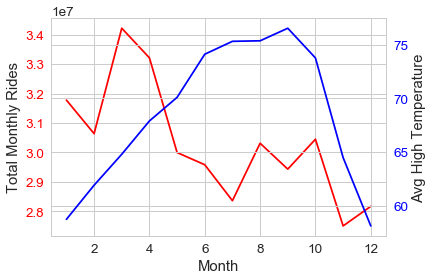

In [124]:
# Create axes
fig, ax = plt.subplots()
ax1, ax2 = two_scales(ax, month_sum_df['month'], month_sum_df['entries'], month_temp_df['max_temperature'], 'r', 'b')

# Change color of each axis
def color_y_axis(ax, color):
    """Color your axes."""
    for t in ax.get_yticklabels():
        t.set_color(color)
    return None
color_y_axis(ax1, 'r')
color_y_axis(ax2, 'b')
#plt.show()

In [126]:
mean_temp_df = bart_weather_df[['max_temperature', 'entries']].groupby(by='max_temperature').mean()
mean_temp_df.reset_index(inplace=True)
#mean_temp_df['month'] = pd.to_numeric(month_sum_df['month'])
#mean_temp_df.sort_values(by='month', inplace=True)

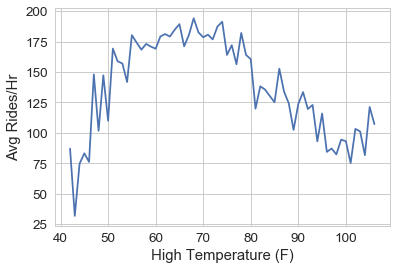

In [152]:
plt.plot(mean_temp_df['max_temperature'], mean_temp_df['entries'])
plt.xlabel('High Temperature (F)')
plt.ylabel('Avg Rides/Hr')
plt.savefig(figpath + 'temp_trend.png', bbox_inches='tight')

Text(0,0.5,'Avg Rides/Hr')

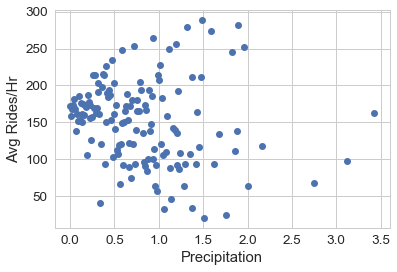

In [133]:
mean_precip_df = bart_weather_df[['precipitation', 'entries']].groupby(by='precipitation').mean()
mean_precip_df.reset_index(inplace=True)
plt.plot(mean_precip_df['precipitation'], mean_precip_df['entries'], 'o')
plt.xlabel('Precipitation')
plt.ylabel('Avg Rides/Hr')

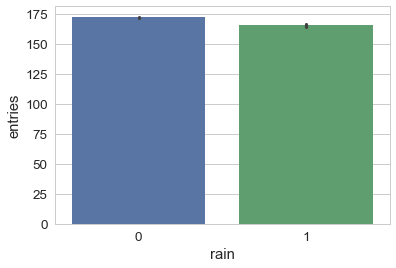

In [144]:
sns.barplot(x=bart_weather_df['rain'], y=bart_weather_df['entries'])